# Neural Collaborative Filtering

In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
import math

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Embedding, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.initializers import RandomUniform, he_normal, he_uniform
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.utils import model_to_dot

In [13]:
train = pd.read_csv("data\\train-plays.csv").drop(columns=["norm_amount", "amount"])
test = pd.read_csv("data\\test-plays.csv").drop(columns=["norm_amount", "amount"])
game_coding = pd.read_csv("data\\game-coding.csv")

## Format training data

In [14]:
train['played'] = 1

In [15]:
rand_users = np.random.randint(0, train.user_id.unique().size, train.shape[0] * 50)
rand_games = np.random.randint(0, train.game_id.unique().size, train.shape[0] * 50)
neg_train = pd.DataFrame({"user_id":rand_users, "game_id":rand_games})
neg_train

,user_id,game_id
0,2124,803
1,2524,455
2,3402,530
3,2755,231
4,3006,16
...,...,...
1994645,1316,804
1994646,766,734
1994647,633,592
1994648,8,292


In [16]:
train = train.append(neg_train).drop_duplicates(subset=['game_id', 'user_id'])
train.played = np.where(train.played != 1, 0, 1)
train = train.sample(frac=1.0)
train

,game_id,user_id,played
923014,941,3279,0
1853215,240,2257,0
680295,536,2330,0
50073,754,3110,0
646013,561,2926,0
...,...,...,...
1497282,151,1120,0
1083072,98,2687,0
754956,619,1267,0
1650357,608,585,0


In [17]:
print(train[train.played == 0].shape[0]/train.shape[0])
print(train[train.played == 1].shape[0]/train.shape[0])

0.9741714976815014
0.025828502318498654


In [18]:
# check to make sure didn't introduce conflicting neg training instances
train.groupby(by=['user_id']).agg({'game_id':lambda x: x.unique().size == x.size})['game_id'].all()

True

## Neural Network Construction

In [106]:
n_latent_factors = 64
n_epochs = 50

### Multi-Layer Perceptron part of model

In [107]:
# game inputs and embeddings
game_input = keras.layers.Input(shape=[1], name='MLP-Game')
game_embedding = keras.layers.Embedding(train.game_id.unique().size, n_latent_factors,
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='MLP-Game-Embedding')(game_input)
game_vec = keras.layers.Flatten(name='MLP-Flatten-Games')(game_embedding)

# user inputs and embeddings
user_input = keras.layers.Input(shape=[1], name='MLP-User')
user_embedding = keras.layers.Embedding(train.user_id.unique().size, n_latent_factors,
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='MLP-User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='MLP-Flatten-Users')(user_embedding)

mlp_layer = keras.layers.concatenate([game_vec, user_vec], name="MLP-User-Games")

for i in [4, 2, 1, 0.5, 0.25, 0]:
  mlp_output = Dense(1, activation='sigmoid', kernel_initializer='he_uniform', 
              activity_regularizer=l2(0.01))(mlp_layer)
  mlp_layer = Dense(math.floor(n_latent_factors * i), activation='relu', 
              kernel_initializer='he_uniform', 
              activity_regularizer=l2(0.01))(mlp_layer)
  if i == 4:
    mlp_layer = BatchNormalization()(mlp_layer)
  mlp_layer = Dropout(0.2)(mlp_layer)

mlp = Model(inputs=[user_input, game_input], outputs=mlp_output)
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [108]:
# train mlp weights
early_stop = keras.callbacks.EarlyStopping(monitor='binary_accuracy', min_delta = 0.0001, patience=10)
mlp_history = mlp.fit([train.user_id, train.game_id], train.played, batch_size=256, epochs=n_epochs, callbacks=[early_stop])

Train on 1544534 samples
Epoch 1/50
1544534/1544534 [==============================] - 96s 62us/sample - loss: 0.1409 - binary_accuracy: 0.9736
Epoch 2/50
1544534/1544534 [==============================] - 95s 61us/sample - loss: 0.1044 - binary_accuracy: 0.9741
Epoch 3/50
1544534/1544534 [==============================] - 95s 61us/sample - loss: 0.0991 - binary_accuracy: 0.9741
Epoch 4/50
1544534/1544534 [==============================] - 96s 62us/sample - loss: 0.0979 - binary_accuracy: 0.9741
Epoch 5/50
1544534/1544534 [==============================] - 94s 61us/sample - loss: 0.0973 - binary_accuracy: 0.9741
Epoch 6/50
1544534/1544534 [==============================] - 94s 61us/sample - loss: 0.0970 - binary_accuracy: 0.9741
Epoch 7/50
1544534/1544534 [==============================] - 83s 54us/sample - loss: 0.0969 - binary_accuracy: 0.9741
Epoch 8/50
1544534/1544534 [==============================] - 72s 47us/sample - loss: 0.0968 - binary_accuracy: 0.9742
Epoch 9/50
1544534/1544

Text(0, 0.5, 'Training Error')

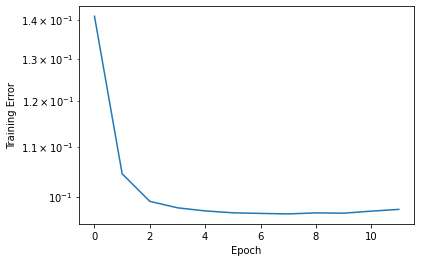

In [109]:
pd.Series(mlp_history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")

In [110]:
# lock mlp weights
mlp.trainable = False
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

### Generalized Matrix Factorization part of model

In [111]:
# game inputs and embeddings
game_input = keras.layers.Input(shape=[1], name='GMF-Game')
game_embedding = keras.layers.Embedding(train.game_id.unique().size, n_latent_factors,
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='GMF-Game-Embedding')(game_input)
game_vec = keras.layers.Flatten(name='GMF-Flatten-Games')(game_embedding)

# user inputs and embeddings
user_input = keras.layers.Input(shape=[1], name='GMF-User')
user_embedding = keras.layers.Embedding(train.user_id.unique().size, n_latent_factors,
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='GMF-User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='GMF-Flatten-Users')(user_embedding)

prod = keras.layers.dot([user_vec, game_vec], axes=1, name='Dot-Product')

gmf = Model(inputs=[user_input, game_input], outputs=prod)
gmf.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [112]:
# train gmf weights
gmf_history = gmf.fit([train.user_id, train.game_id], train.played, batch_size=256, epochs=n_epochs)

Train on 1544534 samples
Epoch 1/50
1544534/1544534 [==============================] - 30s 20us/sample - loss: 0.0231 - mae: 0.0393 - mse: 0.0229
Epoch 2/50
1544534/1544534 [==============================] - 30s 19us/sample - loss: 0.0219 - mae: 0.0423 - mse: 0.0216
Epoch 3/50
1544534/1544534 [==============================] - 31s 20us/sample - loss: 0.0210 - mae: 0.0431 - mse: 0.0205
Epoch 4/50
1544534/1544534 [==============================] - 30s 19us/sample - loss: 0.0204 - mae: 0.0430 - mse: 0.0198
Epoch 5/50
1544534/1544534 [==============================] - 30s 19us/sample - loss: 0.0200 - mae: 0.0427 - mse: 0.0193
Epoch 6/50
1544534/1544534 [==============================] - 30s 19us/sample - loss: 0.0197 - mae: 0.0424 - mse: 0.0189
Epoch 7/50
1544534/1544534 [==============================] - 30s 19us/sample - loss: 0.0195 - mae: 0.0422 - mse: 0.0186
Epoch 8/50
1544534/1544534 [==============================] - 30s 19us/sample - loss: 0.0193 - mae: 0.0418 - mse: 0.0183
Epoch 9

Text(0, 0.5, 'Training Error')

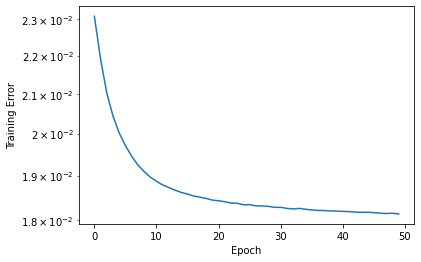

In [113]:
pd.Series(gmf_history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")

In [114]:
# lock gmf weights
gmf.trainable = False
gmf.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [115]:
# Combining MLP and GMF parts of the model
mlp_gmf = Concatenate()([mlp.output, gmf.output])
ncf_output = keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_uniform', name='NCF-Output')(mlp_gmf)
ncf = Model([mlp.input, gmf.input], ncf_output)
ncf.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [116]:
ncf.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
MLP-Game (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
MLP-User (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
MLP-Game-Embedding (Embedding)  (None, 1, 64)        66112       MLP-Game[0][0]                   
__________________________________________________________________________________________________
MLP-User-Embedding (Embedding)  (None, 1, 64)        218048      MLP-User[0][0]                   
___________________________________________________________________________________________

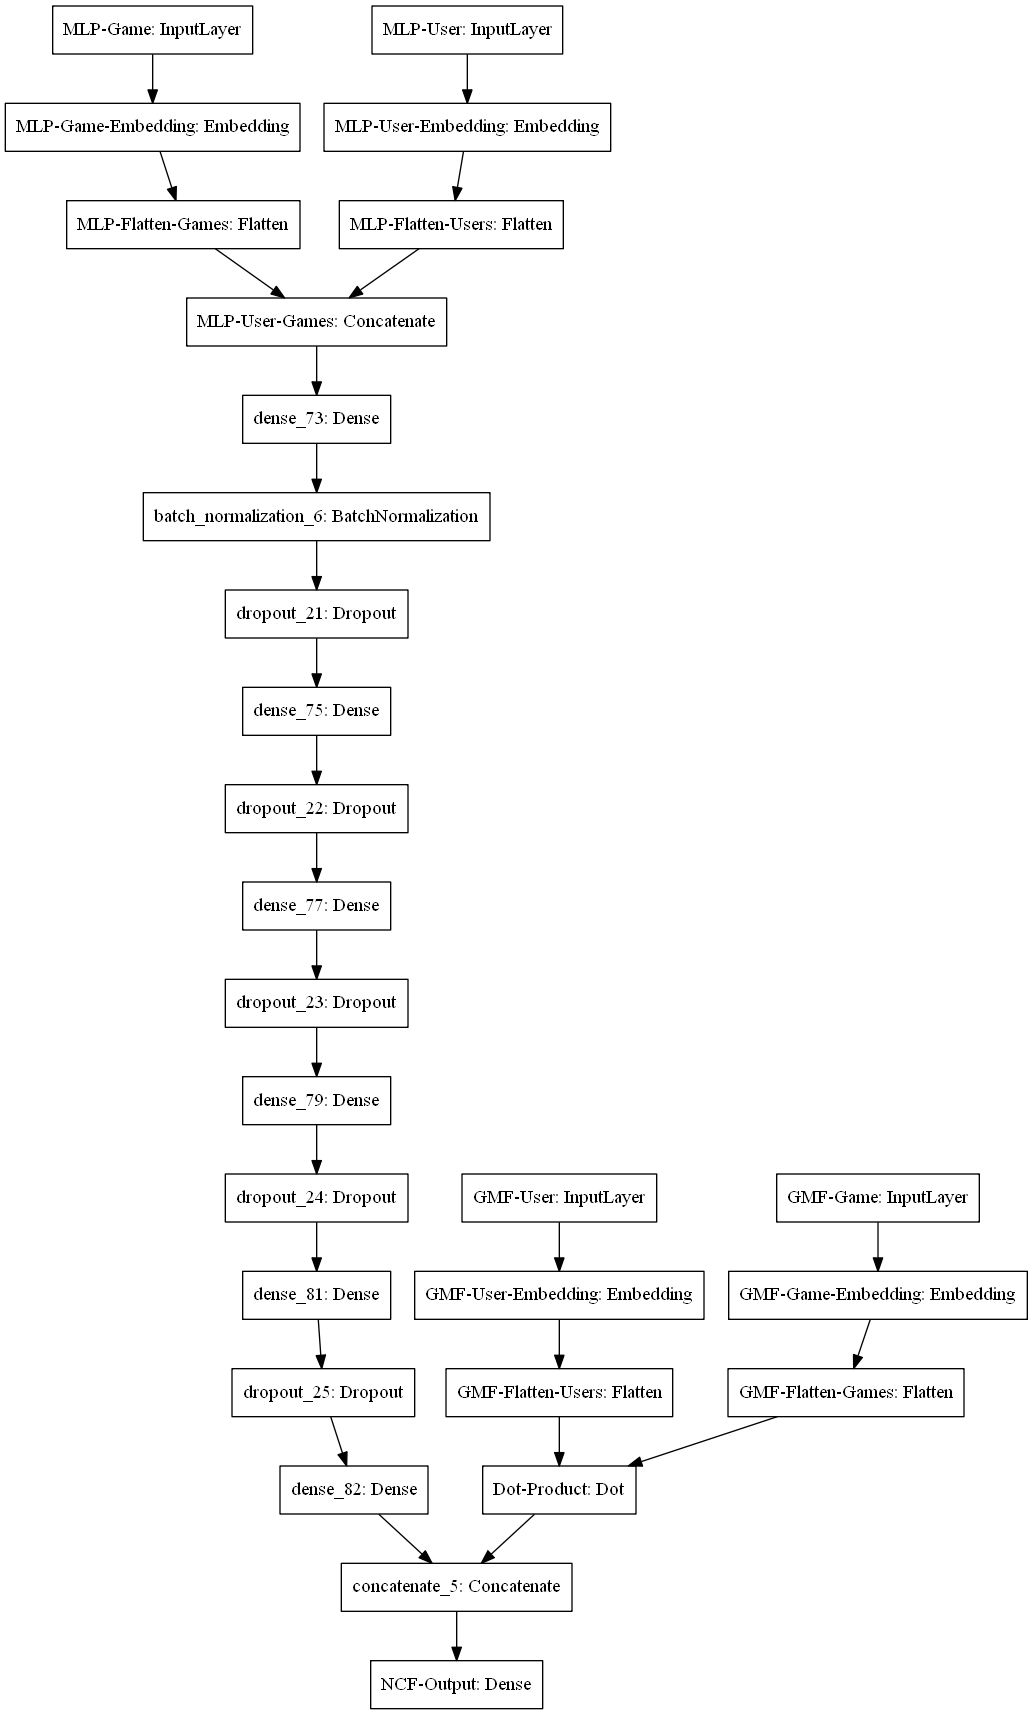

In [117]:
plot_model(ncf)

## Model Training

In [ ]:
# train ncf
early_stop = keras.callbacks.EarlyStopping(monitor='binary_accuracy', min_delta = 0.0001, patience=10)
ncf_history = ncf.fit([train.user_id, train.game_id, train.user_id, train.game_id], train.played, batch_size=256, epochs=n_epochs, callbacks=[early_stop])

In [ ]:
pd.Series(ncf_history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")

## Model Analysis

In [120]:
def recommend_game(uid, model, n=10):
    uid_array = np.repeat(uid, game_coding.game_id.size)
    recs = np.ndarray.flatten(model.predict([uid_array, game_coding.game_id, uid_array, game_coding.game_id]))
    recs_df =  pd.DataFrame({'game_id':game_coding.game_id, 'rec_confidence':recs})
    return set(recs_df.sort_values(by='rec_confidence', ascending=False).head(10).game_id)

In [121]:
test['recommended'] = np.vectorize(recommend_game)(test.user_id.unique(), ncf)

KeyboardInterrupt: 

In [105]:
test['in_recommendations'] = np.vectorize(lambda gid, recs: 1 if gid in recs else 0)(test.game_id, test.recommended)
test.in_recommendations.sum() / test.in_recommendations.size

0.24009392427355444

In [36]:
games_recommended = set()
np.vectorize(lambda curr_games, total: total.update(curr_games))(test.recommended, games_recommended)

array([None, None, None, ..., None, None, None], dtype=object)

In [37]:
len(games_recommended) / train.game_id.unique().size

0.17424975798644723

In [33]:
test

,game_id,user_id,recommended,in_recommendations
0,16,0,"{1, 4, 5, 6, 7, 8, 9, 168, 23, 27}",0
1,35,1,"{1, 39, 73, 74, 141, 20, 151, 25, 26, 63}",0
2,203,2,"{1, 98, 171, 499, 244, 84, 23, 183, 218, 316}",0
3,265,3,"{0, 1, 385, 163, 40, 109, 141, 20, 23, 89}",0
4,286,4,"{0, 1, 7, 168, 333, 211, 23, 89, 27, 285}",0
...,...,...,...,...
1155,584,1155,"{678, 682, 141, 785, 278, 344, 346, 349, 382, ...",0
1156,656,1156,"{544, 353, 931, 807, 171, 109, 399, 656, 343, ...",1
1157,973,1157,"{544, 353, 931, 807, 399, 336, 278, 343, 953, ...",0
1158,901,1158,"{544, 353, 931, 807, 171, 109, 399, 656, 343, ...",0
